In [1]:
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

df_annotations = pd.read_csv("../../data/ctgov/annotations/all_annotations.csv")


# Get data

In [2]:
with open("../../data/ctgov/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [3]:
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    texts.append(" ".join(pages))
df_annotations["text"] = texts

In [18]:
df_annotations_num_arms_known = df_annotations[~df_annotations.num_arms.isna()]

In [19]:
df_annotations_num_arms_known = df_annotations_num_arms_known.sample(1000)

In [20]:
def get_num_arms_clean(num):
    if num >= 5:
        num = 5
    return num
df_annotations_num_arms_known["num_arms_clean"] = df_annotations_num_arms_known["num_arms"].apply(get_num_arms_clean)

# Train and evaluate the number of arms extractor

In [36]:
sys.path.append("../../front_end")
from util.page_tokeniser import tokenise_pages, tokenise_text, tokenise_text_and_lowercase

In [40]:
def get_relevant_text(text):
    relevant_tokens = []
    tokens = list(tokenise_text_and_lowercase(text))
    for idx, token in enumerate(tokens):
        if token in {"arm", "group", "subgroup", "cohort", "arms", "groups", "subgroups", "cohorts"}:
            for j in range(idx - 5, idx + 5):
                if j >= 0 and j < len(tokens):
                    relevant_tokens.append(tokens[j])
        elif token in {
                    "randomise", "randomize", "randomisation", "randomization", "randomised", "randomized",
                    "placebo", "unblinded", "unblinding", "blinded", "blinding", "blind", "compare", "double",
                    "controlled", "control", "differences", "vs", "outcomes", "hypothesis", "experimental", "compared",
                    "effects", "variables", "variables", "ratio", "versus", "outcome", "monotherapy", "polytherapy", "proprietary",
                    "criterion", "healthy", "remission", "separately", "separate", "separated", "assay", "dosing", "dose", "doses",
                    "treatment", "treatments", "study", "studies", "either", "both"}:
            relevant_tokens.append(tokens[idx])
    return " ".join(relevant_tokens)

In [41]:
df_annotations_num_arms_known["relevant_text"] = df_annotations_num_arms_known.text.apply(get_relevant_text)

In [42]:
df_train = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "train"]

In [52]:
df_train.num_arms_clean.value_counts()

2.0    352
1.0    203
3.0    112
5.0     63
4.0     60
Name: num_arms_clean, dtype: int64

In [43]:
df_val = df_annotations_num_arms_known[df_annotations_num_arms_known.train_val == "val"]

In [44]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [45]:
NUM_FEATURES = 1500

stops = set(stopwords.words('english')).union(set(stopwords.words('french')))
stops.remove("both")
stops.remove("all")

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, stop_words=stops, min_df=5, max_features=NUM_FEATURES,
                             token_pattern=r'[59][05]%?(?:ci)?|[a-z][a-z]+')
transformer = TfidfTransformer()

nb = MultinomialNB()
model = make_pipeline(vectoriser, transformer, nb)

In [46]:
model.fit(df_train.relevant_text, df_train.num_arms_clean)

/media/thomas/642d0db5-2c98-4156-b591-1a3572c5868c/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['taient', 'tais', 'tait', 'tant', 'tante', 'tantes', 'tants', 'tiez', 'tions'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=1500, min_df=5,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ai', 'aie',
                                             'aient', 'aies', 'ain', 'ait',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'au',
                                             'aura', 'aurai', 'auraient',
                                             'aurais', 'aurait', 'auras',
                                             'aurez', 'auriez', ...},
                                 token_pattern='[59][05]%?(?:ci)?|[a-z][a-z]+')),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB())])

In [47]:
pred_num_arms = model.predict(df_val.relevant_text)

In [48]:
num_arms_ground_truths = df_val.num_arms_clean

In [49]:
acc = accuracy_score(num_arms_ground_truths, pred_num_arms)
print (f"Num arms accuracy {acc}")

Num arms accuracy 0.4423076923076923


''

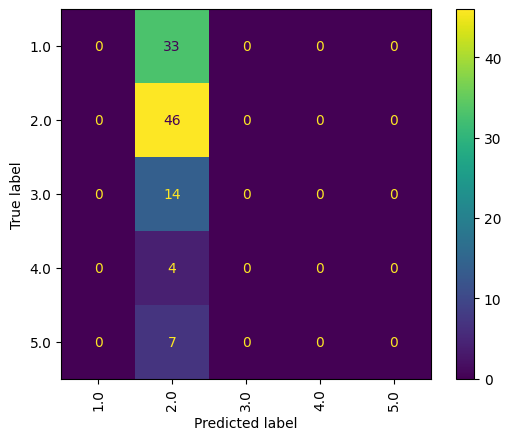

In [50]:
ConfusionMatrixDisplay.from_predictions(num_arms_ground_truths, pred_num_arms)
plt.xticks(rotation=90)
;

In [51]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in range(5):
    print(f"Strongest predictors for class {prediction_idx}\n")
    for i in range(transformed_document.shape[1]):
        zeros = np.zeros(transformed_document.shape)
        zeros[0, i] = transformed_document[0, i]
        proba = nb.predict_log_proba(zeros)
        probas[i] = proba[0, prediction_idx]

    for ctr, j in enumerate(np.argsort(-probas)):
        for w, i in vectoriser.vocabulary_.items():
            if i == j:
                print(f"{ctr}\t{w}")

Strongest predictors for class 0

0	july
1	university
2	everolimus
3	myeloma
4	historical
5	remission
6	cll
7	phone
8	radiation
9	single
10	races
11	expansion
12	biopsy
13	german
14	run
15	mds
16	ps
17	marrow
18	label
19	malignant
20	optional
21	ii
22	international
23	rcc
24	vein
25	pilot
26	infections
27	open
28	sc
29	mtd
30	clinic
31	leukemia
32	dosed
33	transplant
34	exception
35	extension
36	nsclc
37	carcinoma
38	oncology
39	stage
40	european
41	molecular
42	heterogeneous
43	imwg
44	office
45	prostate
46	hematologic
47	explored
48	pharmacovigilance
49	part
50	bevacizumab
51	paclitaxel
52	irb
53	recurrent
54	effective
55	national
56	institute
57	eligible
58	advanced
59	african
60	formal
61	found
62	switch
63	cell
64	cytometry
65	adaptive
66	refractory
67	fda
68	exposed
69	presenting
70	scenario
71	window
72	board
73	working
74	premedication
75	legs
76	mutant
77	lenalidomide
78	twice
79	ethnic
80	true
81	vary
82	several
83	canadian
84	lymphoma
85	lung
86	intermediate
87	nature
88	acc

0	randomisation
1	intervention
2	two
3	randomization
4	randomised
5	placebo
6	blind
7	care
8	test
9	blinded
10	unblinding
11	randomized
12	randomize
13	arm
14	standard
15	unblinded
16	double
17	arms
18	pain
19	per
20	participants
21	compare
22	parallel
23	saline
24	function
25	patients
26	program
27	variables
28	difference
29	using
30	donor
31	atezolizumab
32	assigned
33	groups
34	controlled
35	effects
36	risk
37	receive
38	women
39	differences
40	control
41	compared
42	group
43	subjects
44	continuation
45	vs
46	ratio
47	blinding
48	proprietary
49	assignment
50	total
51	size
52	children
53	both
54	primary
55	active
56	versus
57	hypothesis
58	experimental
59	outcomes
60	alone
61	outcome
62	study
63	according
64	analysis
65	95%
66	use
67	subgroup
68	sample
69	approximately
70	iv
71	trial
72	patient
73	one
74	usual
75	ml
76	baseline
77	criterion
78	summarized
79	follow
80	either
81	visit
82	treatment
83	analyses
84	time
85	mortality
86	normal
87	studies
88	medical
89	sided
90	sequential
9

1170	true
1171	region
1172	mk
1173	focus
1174	leukemia
1175	obtained
1176	infusions
1177	continued
1178	gastrointestinal
1179	moderate
1180	identification
1181	centrally
1182	removed
1183	investigate
1184	half
1185	preceding
1186	listing
1187	squamous
1188	ca
1189	obtain
1190	tumors
1191	binomial
1192	metastatic
1193	maintenance
1194	preparation
1195	termination
1196	abiraterone
1197	supported
1198	run
1199	died
1200	dor
1201	progressive
1202	lowest
1203	consists
1204	eot
1205	multiplicity
1206	hodgkin
1207	detailed
1208	old
1209	tolerated
1210	utilized
1211	aggregate
1212	exceed
1213	immediately
1214	th
1215	nausea
1216	apparent
1217	cleared
1218	bevacizumab
1219	graphically
1220	decisions
1221	circumference
1222	discontinue
1223	skin
1224	sequence
1225	ast
1226	measurable
1227	preferably
1228	alternative
1229	replaced
1230	conditions
1231	predicted
1232	line
1233	st
1234	futility
1235	mri
1236	posterior
1237	poor
1238	lesion
1239	meddra
1240	pancreatic
1241	sections
1242	route
1243	t

1360	multi
1361	iii
1362	controlled
1363	sided
1364	across
1365	years
1366	groups
1367	estimated
1368	remission
1369	collaborative
1370	inc
1371	alone
1372	visit
1373	compare
1374	comparator
1375	similar
1376	design
1377	assigned
1378	least
1379	stopping
1380	dosing
1381	evaluable
1382	blind
1383	antiviral
1384	baseline
1385	primary
1386	non
1387	separated
1388	ii
1389	events
1390	ml
1391	test
1392	monotherapy
1393	subjects
1394	sc
1395	median
1396	lower
1397	randomly
1398	health
1399	arm
1400	normal
1401	weight
1402	sample
1403	upper
1404	working
1405	eastern
1406	level
1407	per
1408	randomized
1409	status
1410	survival
1411	blood
1412	year
1413	group
1414	based
1415	would
1416	cooperative
1417	vaccination
1418	usual
1419	ecog
1420	expansion
1421	higher
1422	protocol
1423	data
1424	unblinded
1425	trial
1426	approximately
1427	university
1428	use
1429	characteristics
1430	post
1431	blinding
1432	age
1433	women
1434	medical
1435	cells
1436	separate
1437	vs
1438	performance
1439	trials
1

1374	therapy
1375	received
1376	survival
1377	kg
1378	50
1379	least
1380	medical
1381	version
1382	enrolled
1383	summarized
1384	international
1385	used
1386	ethnic
1387	time
1388	include
1389	arms
1390	randomised
1391	performance
1392	mg
1393	escalation
1394	optional
1395	using
1396	unblinding
1397	prospective
1398	sequential
1399	baseline
1400	visit
1401	multicenter
1402	based
1403	data
1404	high
1405	all
1406	weeks
1407	size
1408	difference
1409	one
1410	according
1411	randomize
1412	total
1413	clinical
1414	protocol
1415	blood
1416	unblinded
1417	analysis
1418	blind
1419	separately
1420	subgroup
1421	subject
1422	test
1423	working
1424	trials
1425	ecog
1426	week
1427	label
1428	per
1429	rate
1430	months
1431	differences
1432	subgroups
1433	intervention
1434	age
1435	open
1436	healthy
1437	chemotherapy
1438	ii
1439	combination
1440	phase
1441	risk
1442	groups
1443	treated
1444	placebo
1445	separate
1446	eastern
1447	experimental
1448	blinded
1449	blinding
1450	trial
1451	double
1452

1429	receive
1430	unblinding
1431	eastern
1432	nivolumab
1433	non
1434	parallel
1435	week
1436	subgroup
1437	analysis
1438	blind
1439	dosing
1440	alone
1441	clinical
1442	doses
1443	difference
1444	double
1445	healthy
1446	separate
1447	months
1448	dose
1449	rate
1450	blinding
1451	patient
1452	prospective
1453	cooperative
1454	treatments
1455	assay
1456	care
1457	using
1458	arms
1459	standard
1460	groups
1461	children
1462	trial
1463	blinded
1464	placebo
1465	either
1466	risk
1467	ratio
1468	group
1469	randomized
1470	randomization
1471	differences
1472	remission
1473	controlled
1474	test
1475	oncology
1476	treatment
1477	arm
1478	outcome
1479	both
1480	variables
1481	cancer
1482	hypothesis
1483	study
1484	outcomes
1485	compared
1486	versus
1487	compare
1488	studies
1489	monotherapy
1490	control
1491	two
1492	research
1493	effects
1494	intervention
1495	randomised
1496	experimental
1497	patients
1498	vs
1499	randomisation
